<div class="alert alert-info">
<h1> <b>Key Results</b> </h1>
<br>
Takes in results of Monte Carlo simulations and generates key results used in the paper. <br>
Quotes are provided to give context for how results are used in the final publication
</div>

<div class="alert alert-info">
<b>Table of Contents</b> <br><br>
1. <a href="#choropleths">Data for Choropleths</a> <br>
2. <a href="#overall">Overall Access Numbers</a> <br>
3. <a href="#cycling_walking">Cycling vs Walking</a> <br>
4. <a href="#piped">Relationship between piped access and GCIL water access</a>
</div>

In [21]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import weightedstats as ws
from tabulate import tabulate
from scipy.stats import spearmanr

In [22]:
# Constants to save new results (will overwrite existing results)
SAVE_CSVS = False
SAVE_FIGURES = False

In [23]:
# Read country-level results from Monte Carlo sims
country_medians = pd.read_csv("../results/country_median_results.csv")
country_means = pd.read_csv("../results/country_mean_results.csv")
country_5th_percentiles = pd.read_csv("../results/country_5th_percentile_results.csv")
country_95th_percentiles = pd.read_csv("../results/country_95th_percentile_results.csv")

# Read district-level results from Monte Carlo sims
district_medians = pd.read_csv("../results/districts_median_results.csv")
district_means = pd.read_csv("../results/districts_mean_results.csv")
district_5th_percentiles = pd.read_csv("../results/districts_5th_percentile_results.csv")
district_95th_percentiles = pd.read_csv("../results/districts_95th_percentile_results.csv")

# Create simple one-row dataframes with global data
global_median = country_medians[country_medians["ISOCODE"] == "GLOBAL"].reset_index(drop=True)
global_mean = country_means[country_means["ISOCODE"] == "GLOBAL"].reset_index(drop=True)
global_5th_percentile = country_5th_percentiles[country_5th_percentiles["ISOCODE"] == "GLOBAL"].reset_index(drop=True)
global_95th_percentile = country_95th_percentiles[country_95th_percentiles["ISOCODE"] == "GLOBAL"].reset_index(drop=True)

# Drop global from all dataframes
country_medians = country_medians[country_medians["ISOCODE"] != "GLOBAL"]
country_means = country_means[country_means["ISOCODE"] != "GLOBAL"]
country_5th_percentiles = country_5th_percentiles[country_5th_percentiles["ISOCODE"] != "GLOBAL"]
country_95th_percentiles = country_95th_percentiles[country_95th_percentiles["ISOCODE"] != "GLOBAL"]
# No need to drop from district-level dataframes as they don't have a global entry


FileNotFoundError: [Errno 2] No such file or directory: '../results/districts_mean_results.csv'

In [ ]:
global_median

,Unnamed: 0,ISOCODE,country_pop_raw,country_pop_with_water,country_pop_without_water,population_piped_with_access,population_piped_with_cycling_access,population_piped_with_walking_access,population_piped_with_only_cycling_access,NATPiped,...,weighted_95th_walking,percent_with_water,percent_without_water,percent_piped_with_cycling_access,percent_piped_with_walking_access,proportion_piped_access_from_cycling,percent_with_only_cycling_access,Entity,region,subregion
0,59,GLOBAL,7.849191e+09,6.004312e+09,1.843789e+09,3.210513e+09,2.110244e+09,2.232672e+09,9.701135e+08,NaN,...,3.793616,76.495941,23.490179,26.884863,28.44461,30.508709,12.359408,Global,NaN,NaN


In [5]:
# Create formatted country results with 90% CIs

# Read the CSV files
median_df = country_medians
p5_df = country_5th_percentiles
p95_df = country_95th_percentiles
output_file = '../results/country_CI_results.csv'

# Function to rename columns (excluding identifiers)
def rename_columns(df, suffix):
    cols = df.columns.tolist()
    rename_dict = {}
    for col in cols:
        if col not in ['ISOCODE', 'Entity', 'region', 'subregion']:
            rename_dict[col] = f"{col}_{suffix}"
    df = df.rename(columns=rename_dict)
    return df

# Rename columns in each DataFrame
median_df = rename_columns(median_df, 'median')
p5_df = rename_columns(p5_df, 'p5')
p95_df = rename_columns(p95_df, 'p95')

# Merge the DataFrames on common identifiers
df = median_df.merge(p5_df, on=['ISOCODE', 'Entity', 'region', 'subregion'])
df = df.merge(p95_df, on=['ISOCODE', 'Entity', 'region', 'subregion'])

# List of metrics to calculate CI for
metrics = [
    'percent_with_water',
    'percent_without_water',
    'percent_piped_with_cycling_access',
    'percent_piped_with_walking_access',
    'percent_with_only_cycling_access',
    # Add other metrics as needed
]

# Initialize a new DataFrame to store results
results_df = pd.DataFrame()
results_df['ISOCODE'] = df['ISOCODE']
results_df['Entity'] = df['Entity']
results_df['region'] = df['region']
results_df['subregion'] = df['subregion']

# For each metric, add median values and CI strings
for metric in metrics:
    median_col = metric + '_median'
    p5_col = metric + '_p5'
    p95_col = metric + '_p95'

    # Extract the median, p5, and p95 values
    median_values = df[median_col]
    p5_values = df[p5_col]
    p95_values = df[p95_col]

    # Add the median values as numeric columns
    results_df[metric + '_median'] = median_values

    # Create the CI string
    ci_strings = median_values.round(1).astype(str) + '% (90% CI ' + \
                 p5_values.round(1).astype(str) + '–' + \
                 p95_values.round(1).astype(str) + '%)'

    # Add the formatted string to the results DataFrame
    results_df[metric + '_CI'] = ci_strings

# Save the results to a CSV file
if SAVE_CSVS:
    results_df.to_csv(output_file, index=False)

In [ ]:
# Define a function to calculate percent without water
def calculate_percent(df, group):
    data = df.groupby(group).sum()
    percent_without_water = (data['country_pop_without_water'] / data['country_pop_raw']) * 100
    return percent_without_water

# Calculate percent without water for each DataFrame
region_percent_without_water_median = calculate_percent(country_medians, "region")
region_percent_without_water_5th = calculate_percent(country_5th_percentiles, "region")
region_percent_without_water_95th = calculate_percent(country_95th_percentiles, "region")

# Merge results into a single DataFrame
region_percent_without_water = pd.DataFrame({
    'median': region_percent_without_water_median,
    '5th_percentile': region_percent_without_water_5th,
    '95th_percentile': region_percent_without_water_95th
})

# Repeat for subregions
subregion_percent_without_water_median = calculate_percent(country_medians, "subregion")
subregion_percent_without_water_5th = calculate_percent(country_5th_percentiles, "subregion")
subregion_percent_without_water_95th = calculate_percent(country_95th_percentiles, "subregion")

# Merge results into a single DataFrame
subregion_percent_without_water = pd.DataFrame({
    'median': subregion_percent_without_water_median,
    '5th_percentile': subregion_percent_without_water_5th,
    '95th_percentile': subregion_percent_without_water_95th
})

# Define formatting function
def format_results(row):
    median = round(row['median'], 1)
    p5th = round(row['5th_percentile'], 1)
    p95th = round(row['95th_percentile'], 1)
    return f"{median} ({p5th}–{p95th})"

# Apply formatting function to each row
region_percent_without_water['formatted_results'] = region_percent_without_water.apply(format_results, axis=1)
subregion_percent_without_water['formatted_results'] = subregion_percent_without_water.apply(format_results, axis=1)

# Print results
print(region_percent_without_water.sort_values(by='median', ascending=False))
print(subregion_percent_without_water.sort_values(by='median', ascending=False))

if SAVE_CSVS:
    region_percent_without_water.to_csv("../results/region_results.csv", index=True)
    subregion_percent_without_water.to_csv("../results/subregion_results.csv", index=True)

             median  5th_percentile  95th_percentile formatted_results
region                                                                
Americas  37.867498       25.593881        53.332844  37.9 (25.6–53.3)
Europe    23.618637       11.691853        41.185440  23.6 (11.7–41.2)
Africa    22.389855       15.826232        30.021492  22.4 (15.8–30.0)
Asia      20.629464       12.805813        31.384983  20.6 (12.8–31.4)
Oceania   17.966750        9.440304        31.580252   18.0 (9.4–31.6)
                                    median  5th_percentile  95th_percentile  \
subregion                                                                     
Polynesia                        67.375802       43.636413        84.927880   
Western Asia                     53.553256       42.506040        65.737258   
Northern Africa                  44.649543       33.963872        59.919310   
Latin America and the Caribbean  40.681992       28.341901        55.925678   
Northern America             

<div class="alert alert-info">
<h3> <b>1. Data for Choropleths </b> </h3>
<a id="choropleths"></a>
Simplified data to export to Datawrapper for making maps of water access loss in GCIL.
</div>

<div class="alert alert-info">
<h3> <b>2. Overall Access Numbers </b> </h3>
<a id="overall"></a>
Overall access (walking and cycling) for the world, and select countries
</div>

In [7]:
#add required extras
country_means["percent_piped_with_access"] = country_means["population_piped_with_access"] / country_means["country_pop_raw"] * 100
country_means["piped_calculated"] = country_means["percent_without_water"] + country_means["percent_piped_with_access"]

# Add required extras for 5th percentiles
country_5th_percentiles["percent_piped_with_access"] = country_5th_percentiles["population_piped_with_access"] / country_5th_percentiles["country_pop_raw"] * 100
country_5th_percentiles["piped_calculated"] = country_5th_percentiles["percent_without_water"] + country_5th_percentiles["percent_piped_with_access"]

# Add required extras for 95th percentiles
country_95th_percentiles["percent_piped_with_access"] = country_95th_percentiles["population_piped_with_access"] / country_95th_percentiles["country_pop_raw"] * 100
country_95th_percentiles["piped_calculated"] = country_95th_percentiles["percent_without_water"] + country_95th_percentiles["percent_piped_with_access"]


country_medians["percent_piped_with_access"] = country_medians["population_piped_with_access"] / country_medians["country_pop_raw"] * 100
country_medians["piped_calculated"] = country_medians["percent_without_water"] + country_medians["percent_piped_with_access"]


In [8]:
# Overall global population without water
global_median_percentage_without_water = country_medians["country_pop_without_water"].sum() / country_medians["country_pop_raw"].sum()
global_5th_percentage_without_water = country_5th_percentiles["country_pop_without_water"].sum() / country_5th_percentiles["country_pop_raw"].sum()
global_95th_percentage_without_water = country_95th_percentiles["country_pop_without_water"].sum() / country_95th_percentiles["country_pop_raw"].sum()

global_median_percentage_with_water = country_medians["country_pop_with_water"].sum() / country_medians["country_pop_raw"].sum()

# Print overall results
print(f"Global median percentage without water: {global_median_percentage_without_water}")
print(f"Global 5th percentile percentage without water: {global_5th_percentage_without_water}")
print(f"Global 95th percentile percentage without water: {global_95th_percentage_without_water}")

# sense check with percentage with water
print("")
print(f"Global median percentage with water: {global_median_percentage_with_water}")
print("")

Global median percentage without water: 0.23460757580356487
Global 5th percentile percentage without water: 0.14881016785980883
Global 95th percentile percentage without water: 0.34950162499014

Global median percentage with water: 0.7652535872110314



In [9]:
# Piped populations without water
proportion_with_water_piped_median = country_medians["population_piped_with_access"].sum() / country_medians["country_pop_with_water"].sum()
proportion_with_water_piped_5th = country_5th_percentiles["population_piped_with_access"].sum() / country_5th_percentiles["country_pop_with_water"].sum()
proportion_with_water_piped_95th = country_95th_percentiles["population_piped_with_access"].sum() / country_95th_percentiles["country_pop_with_water"].sum()

# Print piped results
# sense check with percentage with water
print(f"Global median percentage with water: {global_median_percentage_with_water}")
print(f"Median proportion with water access who are piped: {proportion_with_water_piped_median}")
print(f"5th percentile proportion with water access who are piped: {proportion_with_water_piped_5th}")
print(f"95th percentile proportion with water access who are piped: {proportion_with_water_piped_95th}")

Global median percentage with water: 0.7652535872110314
Median proportion with water access who are piped: 0.5348470319527824
5th percentile proportion with water access who are piped: 0.45267201203620105
95th percentile proportion with water access who are piped: 0.5817407189151452


In [ ]:
# Define a function to calculate percent without water
def calculate_percent(df, group):
    data = df.groupby(group).sum()
    percent_without_water = (data['country_pop_without_water'] / data['country_pop_raw']) * 100
    return percent_without_water

# Calculate percent without water for each DataFrame
region_percent_without_water_median = calculate_percent(country_medians, "region")
region_percent_without_water_5th = calculate_percent(country_5th_percentiles, "region")
region_percent_without_water_95th = calculate_percent(country_95th_percentiles, "region")

# Merge results into a single DataFrame
region_percent_without_water = pd.DataFrame({
    'median': region_percent_without_water_median,
    '5th_percentile': region_percent_without_water_5th,
    '95th_percentile': region_percent_without_water_95th
})

# Repeat for subregions
subregion_percent_without_water_median = calculate_percent(country_medians, "subregion")
subregion_percent_without_water_5th = calculate_percent(country_5th_percentiles, "subregion")
subregion_percent_without_water_95th = calculate_percent(country_95th_percentiles, "subregion")

# Merge results into a single DataFrame
subregion_percent_without_water = pd.DataFrame({
    'median': subregion_percent_without_water_median,
    '5th_percentile': subregion_percent_without_water_5th,
    '95th_percentile': subregion_percent_without_water_95th
})

# Define formatting function
def format_results(row):
    median = round(row['median'], 1)
    p5th = round(row['5th_percentile'], 1)
    p95th = round(row['95th_percentile'], 1)
    return f"{median} ({p5th}–{p95th})"

# Apply formatting function to each row
region_percent_without_water['formatted_results'] = region_percent_without_water.apply(format_results, axis=1)
subregion_percent_without_water['formatted_results'] = subregion_percent_without_water.apply(format_results, axis=1)

# Print results
print(region_percent_without_water.sort_values(by='median', ascending=False))
print(subregion_percent_without_water.sort_values(by='median', ascending=False))

region_percent_without_water.to_csv("../results/region_results.csv", index=True)
subregion_percent_without_water.to_csv("../results/subregion_results.csv", index=True)

             median  5th_percentile  95th_percentile formatted_results
region                                                                
Americas  37.867498       25.593881        53.332844  37.9 (25.6–53.3)
Europe    23.618637       11.691853        41.185440  23.6 (11.7–41.2)
Africa    22.389855       15.826232        30.021492  22.4 (15.8–30.0)
Asia      20.629464       12.805813        31.384983  20.6 (12.8–31.4)
Oceania   17.966750        9.440304        31.580252   18.0 (9.4–31.6)
                                    median  5th_percentile  95th_percentile  \
subregion                                                                     
Polynesia                        67.375802       43.636413        84.927880   
Western Asia                     53.553256       42.506040        65.737258   
Northern Africa                  44.649543       33.963872        59.919310   
Latin America and the Caribbean  40.681992       28.341901        55.925678   
Northern America             

In [11]:
# Make a single table with the 10 countries with the highest and lowest percentage of people without access to water
country_medians_simple = country_medians[["Entity", "percent_without_water"]].copy()
top10 = country_medians_simple.nlargest(10, "percent_without_water")
bottom10 = country_medians_simple.nsmallest(10, "percent_without_water")
top_bottom = pd.concat([top10, bottom10])

if SAVE_CSVS == True:
    top_bottom.to_csv("../results/top_bottom_10_countries.csv", index=False)

<div class="alert alert-success">Supplementary: Plot of Monte Carlo distribution

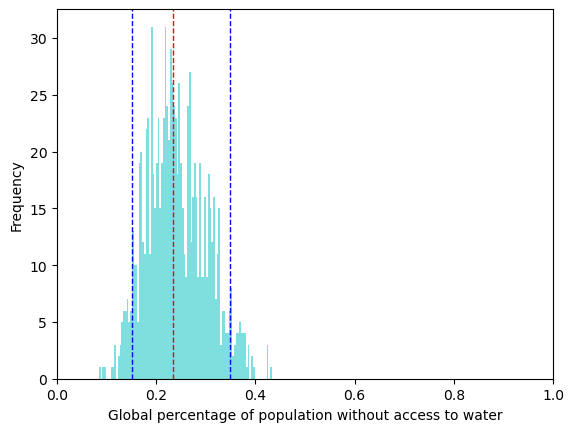

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load pickled simulation results
simulation_results = pd.read_pickle("../results/countries_simulation_results.pkl")




# Drop GLOBAL from simulation results
simulation_results = [df[df.index != 'GLOBAL'] for df in simulation_results]




# Calculate global median percentage without water for each simulation using list comprehension
global_access = [df["country_pop_without_water"].sum() / df["country_pop_raw"].sum() for df in simulation_results]

# Calculate median, 5th percentile, and 95th percentile
median = np.median(global_access)
p5 = np.percentile(global_access, 5)
p95 = np.percentile(global_access, 95)

# Plot histogram of results
fig, ax = plt.subplots()
ax.hist(global_access, bins=100, alpha=0.5, color='c')
ax.set_xlabel("Global percentage of population without access to water")
ax.set_ylabel("Frequency")
# ax.set_title("Distribution of Monte Carlo simulation results")

# Add vertical lines for median, 5th percentile, and 95th percentile
ax.axvline(median, color='red', linestyle='dashed', linewidth=1)
ax.axvline(p5, color='blue', linestyle='dashed', linewidth=1)
ax.axvline(p95, color='blue', linestyle='dashed', linewidth=1)

# Set x-axis limits
ax.set_xlim(0, 1)

if SAVE_FIGURES == True:
    plt.savefig("../results/mc_distribution_no_water.png")
plt.show()

In [13]:
country_medians["percent_piped_with_access"] = country_medians["population_piped_with_access"] / country_medians["country_pop_raw"] * 100
country_medians["piped_calculated"] = country_medians["percent_without_water"] + country_medians["percent_piped_with_access"]


<div class="alert alert-info">
<h3> <b>3. Cycling vs walking results </b> </h3>
<a id="cycling_walking"></a>
</div>

<div class="alert alert-success">Quote from paper: The maximum euclidean distance people could walk one-way to water varied between <b>3.6–4.0 km</b> in the model, approximately equal to travelling 4.8–5.4 km on roads if using a conversion factor of 1.345 (Gonçalves et al., 2014). For cycling, the equivalent euclidean distances were <b>0–17.7 km</b>, equivalent to approximately 0–23.8 km on roads. <br><br> NB: These are currently given as full ranges rather than 90% CIs, as the data is not population-weighted.<br> NB: The minimum cycling distance is negative, but expressed as zero in the paper. This is due to the parameters in some regions having very poor cycling conditions (e.g., very steep, no roads), leading to the model requiring more energy than available to move forwards.


In [14]:
# @JAMES to help figure out, something to do with cycling changes
med_walking = global_median["weighted_med_walking"][0]
p5_walking = global_5th_percentile["weighted_med_walking"][0]
p95_walking = global_95th_percentile["weighted_med_walking"][0]

med_cycling = global_median["weighted_med_cycling"][0]
p5_cycling = global_5th_percentile["weighted_med_cycling"][0]
p95_cycling = global_95th_percentile["weighted_med_cycling"][0]

print(f"Global median walking distance: {med_walking} ({p5_walking}–{p95_walking})")
print(f"Global median cycling distance: {med_cycling} ({p5_cycling}–{p95_cycling})")


Global median walking distance: 3.657486490441764 (1.5589769895645749–6.036765638247514)
Global median cycling distance: 12.457392302678208 (8.08118873633833–16.943531274606425)


In [15]:
# For walking vs cycling breakdown, we are using the mean results instead of median as this will lead to more intuitive comparisons.
# If we use the medians, the sum of the individual walking and cycling access may be very different to the the sum of the total access
# First, let's look at piped only
# country_means["country_pop_piped"] = country_means["country_pop_raw"] * country_means["piped_calculated"] / 100

# global_mean_percentage_piped_with_access = country_means["population_piped_with_access"].sum() / country_means["country_pop_piped"].sum()
# global_mean_piped_percentage_with_cycling_access = country_means["population_piped_with_cycling_access"].sum() / country_means["country_pop_piped"].sum()
# global_mean_piped_percentage_with_walking_access = country_means["population_piped_with_walking_access"].sum() / country_means["country_pop_piped"].sum()
# global_mean_piped_percentage_with_only_cycling_access = (country_means["population_piped_with_access"].sum() - country_means["population_piped_with_walking_access"].sum()) / country_means["country_pop_piped"].sum()

# print(f"Relative to global piped population: mean percentage piped with access: {global_mean_percentage_piped_with_access}")
# print(f"Relative to global piped population: mean percentage piped with cycling access: {global_mean_piped_percentage_with_cycling_access}")
# print(f"Relative to global piped population: mean percentage piped with walking access: {global_mean_piped_percentage_with_walking_access}")
# print(f"Relative to global piped population: mean percentage piped with only cycling access: {global_mean_piped_percentage_with_only_cycling_access}")

In [16]:
# Median, 5th, and 95th percentile results for piped water population
country_medians["country_pop_piped"] = country_medians["country_pop_raw"] * country_medians["NATPiped"] / 100
country_5th_percentiles["country_pop_piped"] = country_5th_percentiles["country_pop_raw"] * country_5th_percentiles["NATPiped"] / 100
country_95th_percentiles["country_pop_piped"] = country_95th_percentiles["country_pop_raw"] * country_95th_percentiles["NATPiped"] / 100



assert (country_medians["country_pop_piped"] == country_5th_percentiles["country_pop_piped"]).all()
assert (country_medians["country_pop_piped"] == country_95th_percentiles["country_pop_piped"]).all()

global_median_piped_percentage_with_cycling_access = country_medians["population_piped_with_cycling_access"].sum() / country_medians["country_pop_piped"].sum()
global_5th_piped_percentage_with_cycling_access = country_5th_percentiles["population_piped_with_cycling_access"].sum() / country_5th_percentiles["country_pop_piped"].sum()
global_95th_piped_percentage_with_cycling_access = country_95th_percentiles["population_piped_with_cycling_access"].sum() / country_95th_percentiles["country_pop_piped"].sum()

print(f"Relative to global piped population: median percentage piped with cycling access: {global_median_piped_percentage_with_cycling_access}")
print(f"Relative to global piped population: 5th percentile percentage piped with cycling access: {global_5th_piped_percentage_with_cycling_access}")
print(f"Relative to global piped population: 95th percentile percentage piped with cycling access: {global_95th_piped_percentage_with_cycling_access}")


Relative to global piped population: median percentage piped with cycling access: 0.4029389989358688
Relative to global piped population: 5th percentile percentage piped with cycling access: 0.33546685234179296
Relative to global piped population: 95th percentile percentage piped with cycling access: 0.4315537326011786


In [17]:
# Now looking at proportions of the global population (piped and non-piped)
# Note that this (country_pop_raw) is also including non-piped population who do not walk/cycle to collect water
# global_mean_percentage_with_access = country_means["population_piped_with_access"].sum() / country_means["country_pop_raw"].sum()
# global_mean_percentage_with_cycling_access = country_means["population_piped_with_cycling_access"].sum() / country_means["country_pop_raw"].sum()
# global_mean_percentage_with_walking_access = country_means["population_piped_with_walking_access"].sum() / country_means["country_pop_raw"].sum()
# global_mean_percentage_with_only_cycling_access = (country_means["population_piped_with_access"].sum() - country_means["population_piped_with_walking_access"].sum()) / country_means["country_pop_raw"].sum()

# print(f"Global mean percentage with access: {global_mean_percentage_with_access}")
# print(f"Global mean percentage with cycling access: {global_mean_percentage_with_cycling_access}")
# print(f"Global mean percentage with walking access: {global_mean_percentage_with_walking_access}")
# print(f"Global mean percentage with only cycling access: {global_mean_percentage_with_only_cycling_access}")

#### Most important countries for bicycles

In [ ]:
# TODO Change to means so walking/cycling split makes sense?
# Calculate top 10 countries by lowest value for global_mean_piped_percentage_with_walking_access
country_medians["percentage_piped_with_walking_access"] = country_medians["population_piped_with_walking_access"] / country_medians["population_piped_with_access"] * 100
country_medians["percentage_piped_with_cycling_access"] = country_medians["population_piped_with_cycling_access"] / country_medians["population_piped_with_access"] * 100
country_medians["percentage_piped_of_total_access"] = country_medians["population_piped_with_access"] / country_medians["country_pop_with_water"] * 100
country_medians["population_piped_with_only_cycling_access"] = country_medians["population_piped_with_access"] - country_medians["population_piped_with_walking_access"]
country_medians["percentage_piped_with_only_cycling_access"] = country_medians["population_piped_with_only_cycling_access"] / country_medians["population_piped_with_access"] * 100
country_medians["percentage_total_with_only_cycling_access"] = country_medians["population_piped_with_only_cycling_access"] / country_medians["country_pop_raw"] * 100

top_piped_cycling_access = country_medians.nlargest(30, "percentage_piped_with_only_cycling_access")
print(tabulate(top_piped_cycling_access[['Entity', "percentage_piped_with_only_cycling_access", "percentage_total_with_only_cycling_access", 'percentage_piped_with_walking_access', 'percentage_piped_with_cycling_access', "percent_with_water"]], headers='keys', tablefmt='psql'))



+-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------+
|     | Entity                           |   percentage_piped_with_only_cycling_access |   percentage_total_with_only_cycling_access |   percentage_piped_with_walking_access |   percentage_piped_with_cycling_access |   percent_with_water |
|-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------|
|   3 | United Arab Emirates             |                                    100      |                                   0.0652233 |                                0       |                               100      |            0.0652233 |
| 145 | San Marino                      

In [19]:
# OR rank by total population that gain access by cycling
top_total_cycling_access = country_medians.nlargest(30, "percentage_total_with_only_cycling_access")
print(tabulate(top_total_cycling_access[['Entity', "percentage_total_with_only_cycling_access", "percentage_piped_with_only_cycling_access", 'percentage_piped_with_walking_access', 'percentage_piped_with_cycling_access', "percent_with_water"]], headers='keys', tablefmt='psql'))

+-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------+
|     | Entity                           |   percentage_total_with_only_cycling_access |   percentage_piped_with_only_cycling_access |   percentage_piped_with_walking_access |   percentage_piped_with_cycling_access |   percent_with_water |
|-----+----------------------------------+---------------------------------------------+---------------------------------------------+----------------------------------------+----------------------------------------+----------------------|
| 145 | San Marino                       |                                     65.63   |                                    100      |                                 0      |                               100      |              65.63   |
|  94 | Liechtenstein                   

<div class="alert alert-success">Supplementary: Plot of Monte Carlo distribution

In [ ]:
# Load pickled simulation results
simulation_results = pd.read_pickle("../results/countries_simulation_results.pkl")

# Drop GLOBAL from simulation results
simulation_results = [df[df.index != 'GLOBAL'] for df in simulation_results]

# Check that GLOBAL is removed from the first dataframe
print("GLOBAL in first dataframe:", 'GLOBAL' in simulation_results[0].index)

# Calculate country_pop_piped for each dataframe in simulation_results
for df in simulation_results:
    df["country_pop_unpiped"] = df["country_pop_raw"] * (100-df["NATPiped"]) / 100

# Calculate global mean percentage for each access type for each simulation using list comprehension
global_access = [df["country_pop_with_water"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_cycling_access = [df["population_piped_with_cycling_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
global_walking_access = [df["population_piped_with_walking_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]
# global_only_cycling_access = [(df["population_piped_with_access"].sum() - df["population_piped_with_walking_access"].sum()) / df["country_pop_raw"].sum() for df in simulation_results]
global_only_cycling_access = [df["population_piped_with_only_cycling_access"].sum() / df["country_pop_raw"].sum() for df in simulation_results]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten axs for easy iteration
axs = axs.flatten()

# List of access types
access_types = [global_access, global_walking_access, global_cycling_access, global_only_cycling_access]

# List of titles
titles = ["(a) Global Total Access", "(b) Global Walking Access", "(c) Global Cycling Access", "(d) Global Only Cycling Access"]

# Plot histogram of results for each access type
for i, ax in enumerate(axs):
    # Calculate median, 5th percentile, and 95th percentile
    median = np.median(access_types[i])
    p5 = np.percentile(access_types[i], 5)
    p95 = np.percentile(access_types[i], 95)

    ax.hist(access_types[i], bins=100, alpha=0.7, color='c')
    ax.set_xlim(0, 1)

    # Add vertical lines for median, 5th percentile, and 95th percentile
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(p5, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(p95, color='blue', linestyle='dashed', linewidth=1)

    # Set title and labels
    ax.set_title(f"{titles[i]}", fontsize=14)

# Set common x-axis label
fig.text(0.5, 0.0, 'Percentage Access', ha='center', va='center', fontsize=14)
fig.text(0.0, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
if SAVE_FIGURES == True:
    plt.savefig("../results/mc_distribution_total_access.png")
plt.show()

GLOBAL in first dataframe: False


KeyboardInterrupt: 

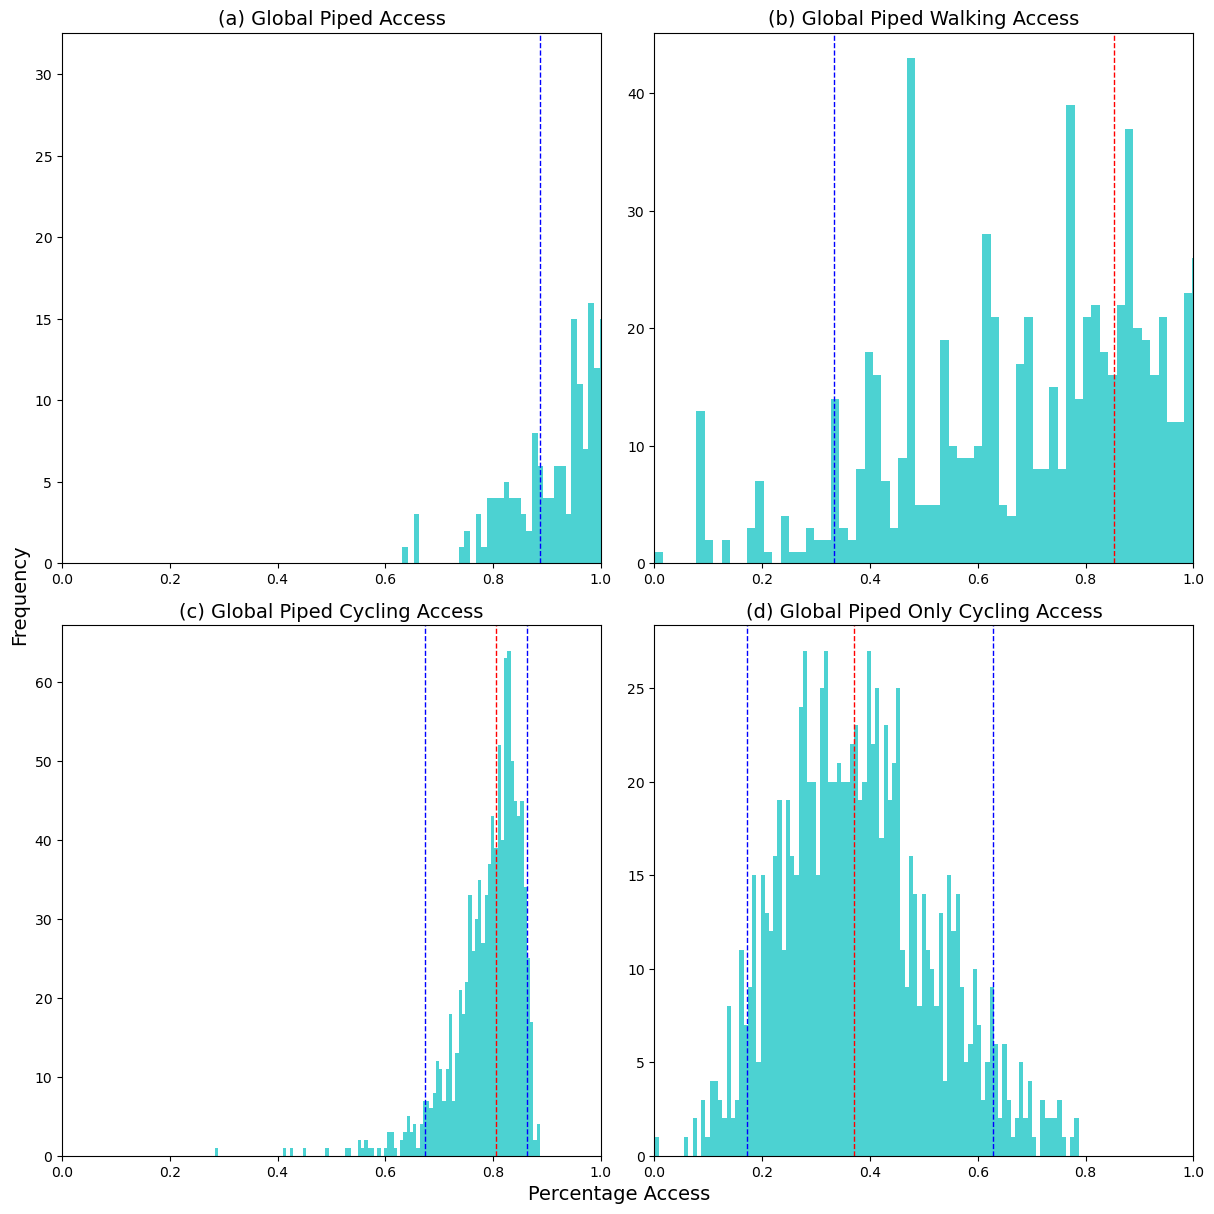

In [24]:
# Load pickled simulation results
simulation_results = pd.read_pickle("../results/countries_simulation_results.pkl")
# Drop GLOBAL from simulation results
simulation_results = [df[df.index != 'GLOBAL'] for df in simulation_results]


# Calculate country_pop_piped for each dataframe in simulation_results
for df in simulation_results:
    df["country_pop_piped"] = df["country_pop_raw"] * df["NATPiped"] / 100

# Calculate global mean percentage for each access type for each simulation using list comprehension
global_piped_access = [df["population_piped_with_access"].sum() / df["country_pop_piped"].sum() for df in simulation_results]
global_piped_cycling_access = [df["population_piped_with_cycling_access"].sum() / df["country_pop_piped"].sum() for df in simulation_results]
global_piped_walking_access = [df["population_piped_with_walking_access"].sum() / df["country_pop_piped"].sum() for df in simulation_results]
global_piped_only_cycling_access = [(df["population_piped_with_access"].sum() - df["population_piped_with_walking_access"].sum()) / df["country_pop_piped"].sum() for df in simulation_results]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten axs for easy iteration
axs = axs.flatten()

# List of access types
access_types = [global_piped_access, global_piped_walking_access, global_piped_cycling_access, global_piped_only_cycling_access]

# List of titles
titles = ["(a) Global Piped Access", "(b) Global Piped Walking Access", "(c) Global Piped Cycling Access", "(d) Global Piped Only Cycling Access"]

# Plot histogram of results for each access type
for i, ax in enumerate(axs):
    # Calculate median, 5th percentile, and 95th percentile
    median = np.median(access_types[i])
    p5 = np.percentile(access_types[i], 5)
    p95 = np.percentile(access_types[i], 95)

    ax.hist(access_types[i], bins=100, alpha=0.7, color='c')
    ax.set_xlim(0, 1)

    # Add vertical lines for median, 5th percentile, and 95th percentile
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(p5, color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(p95, color='blue', linestyle='dashed', linewidth=1)

    # Set title and labels
    ax.set_title(f"{titles[i]}", fontsize=14)

# Set common x-axis label
fig.text(0.5, 0.0, 'Percentage Access', ha='center', va='center', fontsize=14)
fig.text(0.0, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
if SAVE_FIGURES == True:
    plt.savefig("../results/mc_distribution_piped_access.png")
plt.show()

<div class="alert alert-info">
<h3> <b>4. Relationship between piped water access and GCIL water access </b> </h3>
<a id="piped"></a>
</div>


In [25]:
import plotly.express as px

fig = px.scatter(
    country_medians, x="NATPiped", y="piped_calculated", 
    labels={'x':'NATPiped', 'y':'Piped Calculated'}, 
    title="Piped Calculated vs NATPiped",
    # size="bubble_size",
    color="region",
    hover_data=['Entity']
).update_layout(
    width=1200,
    height=800,
).update_xaxes(
    range=[0, 105]
).update_yaxes(
    range=[0, 105]
)

fig.show()

In [26]:
correlation_piped = spearmanr(country_medians["NATPiped"], country_medians["piped_calculated"])
correlation_piped


SignificanceResult(statistic=0.9686257359171735, pvalue=1.4634310038461185e-109)

In [27]:
# Piped water access by country
# create bubble chart from df_countries comprising: access to water, piped water, and using population as the size of the bubble
# create a new column for the size of the bubble

# create bubble size column with square root transformation for improved visuals
country_medians["bubble_size"] = country_medians["country_pop_raw"] **0.5

px.scatter(
    country_medians, 
    y="percent_without_water", 
    # x="NATPiped", 
    x="piped_calculated", 
    size="bubble_size", 
    color="region", 
    hover_name="Entity", 
    # title="Access to Water vs. Piped Water vs. Population",
).update_layout(
    yaxis_title="Country population without access to water (%)",
    xaxis_title="Country piped water access (%)",
    legend_title="Region",
    width=1200,
    height=800,
    font=dict(size=25),
    # xaxis_tickangle=-45,
    # yaxis=dict(tickfont=dict(size=2)),
    # title=dict(font=dict(size=20)),
).update_xaxes(range=[0, 105]).update_yaxes(range=[0, 105])

In [28]:
# Check for correlation using median, 5th, and 95th percentiles
# correlation_scipy = spearmanr(country_medians["percent_without_water"], country_medians["NATPiped"])
# correlation_5th_scipy = spearmanr(country_5th_percentiles["percent_without_water"], country_5th_percentiles["NATPiped"])
# correlation_95th_scipy = spearmanr(country_95th_percentiles["percent_without_water"], country_95th_percentiles["NATPiped"])
# print(f"Spearman correlation between percent_without_water and NATPiped (median) using scipy: {correlation_scipy}")
# print(f"Spearman correlation between percent_without_water and NATPiped (5th) using scipy: {correlation_5th_scipy}")
# print(f"Spearman correlation between percent_without_water and NATPiped (95th) using scipy: {correlation_95th_scipy}")

correlation_scipy = spearmanr(country_medians["percent_without_water"], country_medians["piped_calculated"])
correlation_5th_scipy = spearmanr(country_5th_percentiles["percent_without_water"], country_5th_percentiles["piped_calculated"])
correlation_95th_scipy = spearmanr(country_95th_percentiles["percent_without_water"], country_95th_percentiles["piped_calculated"])
print(f"Spearman correlation between percent_without_water and piped_calculated (median) using scipy: {correlation_scipy}")
print(f"Spearman correlation between percent_without_water and piped_calculated (5th) using scipy: {correlation_5th_scipy}")
print(f"Spearman correlation between percent_without_water and piped_calculated (95th) using scipy: {correlation_95th_scipy}")

Spearman correlation between percent_without_water and piped_calculated (median) using scipy: SignificanceResult(statistic=0.46697862496094134, pvalue=3.8953768594769384e-11)
Spearman correlation between percent_without_water and piped_calculated (5th) using scipy: SignificanceResult(statistic=0.4251592127329032, pvalue=2.696606838321699e-09)
Spearman correlation between percent_without_water and piped_calculated (95th) using scipy: SignificanceResult(statistic=0.682878448674653, pvalue=4.643490290967834e-26)


In [29]:
# Group the data by region
groups = country_medians.groupby('region')

correlations = {}

# Apply the spearmanr function to each group
for name, group in groups:
    correlation, p_value = spearmanr(group["percent_without_water"], group["piped_calculated"])
    correlations[name] = {'correlation': correlation, 'p_value': p_value}

# Convert the correlations dictionary to a DataFrame
correlations_df = pd.DataFrame(correlations).T

print(correlations_df)

          correlation       p_value
Africa       0.840775  6.273226e-15
Americas     0.524398  1.732212e-03
Asia         0.746745  2.539196e-09
Europe      -0.090001  5.757515e-01
Oceania      0.261905  5.309229e-01


<div class="alert alert-warning">That seems perplexing! It may be more robust to check all correlations and create confidence intervals from them. Let's check all correlations for robustness:


In [30]:
# Calculate Spearman correlation for each DataFrame in the list
correlations = [spearmanr(df["percent_without_water"], df["NATPiped"]) for df in simulation_results]

# Remove rows with NaN values in either column before calculating correlations
correlations = [spearmanr(df.dropna(subset=["percent_without_water", "NATPiped"])["percent_without_water"], 
                          df.dropna(subset=["percent_without_water", "NATPiped"])["NATPiped"]) 
                for df in simulation_results]



# Extract correlation statistics and p-values
statistics = [corr.correlation for corr in correlations]
pvalues = [corr.pvalue for corr in correlations]

# Calculate median, 5th and 95th percentiles for statistics
statistics_median = np.median(statistics)
statistics_5th = np.percentile(statistics, 5)
statistics_95th = np.percentile(statistics, 95)

# Calculate median, 5th and 95th percentiles for pvalues
pvalues_median = np.median(pvalues)
pvalues_5th = np.percentile(pvalues, 5)
pvalues_95th = np.percentile(pvalues, 95)

print("Statistics:")
print("Median: ", statistics_median)
print("5th percentile: ", statistics_5th)
print("95th percentile: ", statistics_95th)

print("\nP-values:")
print("Median: ", pvalues_median)
print("5th percentile: ", pvalues_5th)
print("95th percentile: ", pvalues_95th)

Statistics:
Median:  0.4608122672217896
5th percentile:  0.32071072730653166
95th percentile:  0.6091159376000871

P-values:
Median:  8.014719137988254e-11
5th percentile:  1.4101637111302334e-19
95th percentile:  1.203689286378435e-05


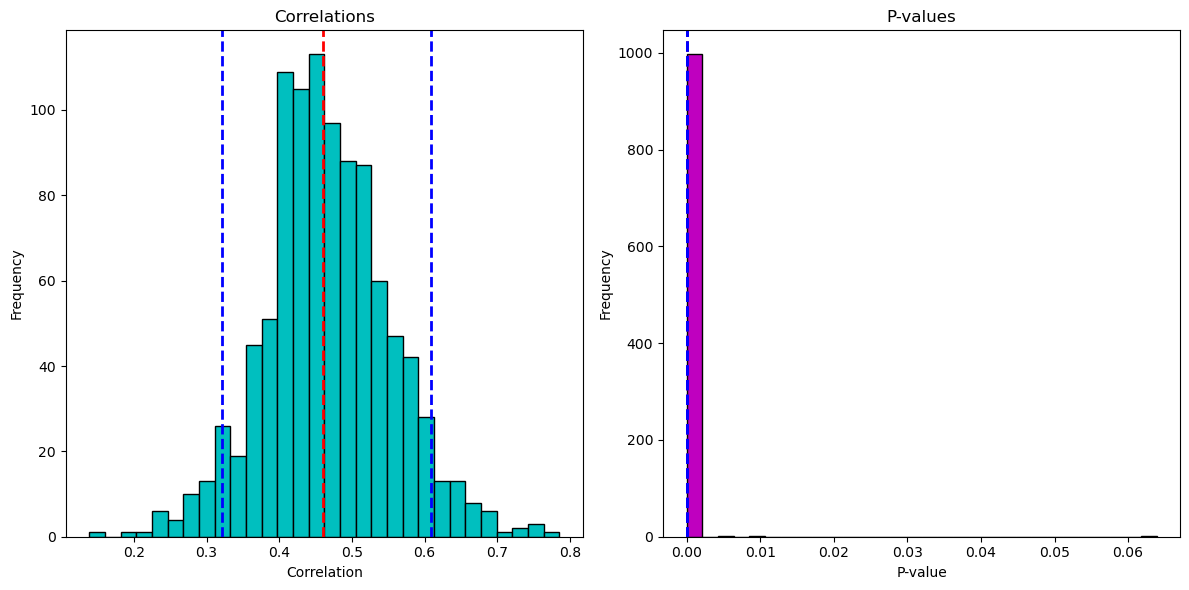

: 

In [ ]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Create a subplot for correlations
plt.subplot(1, 2, 1)
plt.hist(statistics, bins=30, color='c', edgecolor='black')
plt.axvline(statistics_median, color='r', linestyle='dashed', linewidth=2)
plt.axvline(statistics_5th, color='b', linestyle='dashed', linewidth=2)
plt.axvline(statistics_95th, color='b', linestyle='dashed', linewidth=2)
plt.title('Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

# Create a subplot for p-values
plt.subplot(1, 2, 2)
plt.hist(pvalues, bins=30, color='m', edgecolor='black')
plt.axvline(pvalues_median, color='r', linestyle='dashed', linewidth=2)
plt.axvline(pvalues_5th, color='b', linestyle='dashed', linewidth=2)
plt.axvline(pvalues_95th, color='b', linestyle='dashed', linewidth=2)
plt.title('P-values')
plt.xlabel('P-value')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------
# 1. Data Loading
# ------------------------------------
dtype_dict = {
    'fid': np.float64,
    # Add other columns with specific dtypes if necessary
}

# Load the main data
df_main = pd.read_csv('../results/median_results_all_data.csv', dtype=dtype_dict)
df_5th = pd.read_csv('../results/5th_results_all_data.csv', dtype=dtype_dict)
df_95th = pd.read_csv('../results/95th_results_all_data.csv', dtype=dtype_dict)

# ------------------------------------
# 2. Merging Data
# ------------------------------------
df = df_main.merge(df_5th, on='fid', suffixes=('', '_5th'))
df = df.merge(df_95th, on='fid', suffixes=('', '_95th'))


/tmp/ipykernel_322141/1007948810.py:15: DtypeWarning:

Columns (31,37) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_322141/1007948810.py:16: DtypeWarning:

Columns (31,37) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipykernel_322141/1007948810.py:17: DtypeWarning:

Columns (31,37) have mixed types. Specify dtype option on import or set low_memory=False.



Checking for negative values after adjustment:
zone_pop_with_water                     0.0
zone_pop_without_water                  0.0
pop_with_piped                          0.0
pop_without_piped                       0.0
pop_with_piped_and_lost_access          0.0
pop_with_piped_and_maintained_access    0.0
dtype: float64


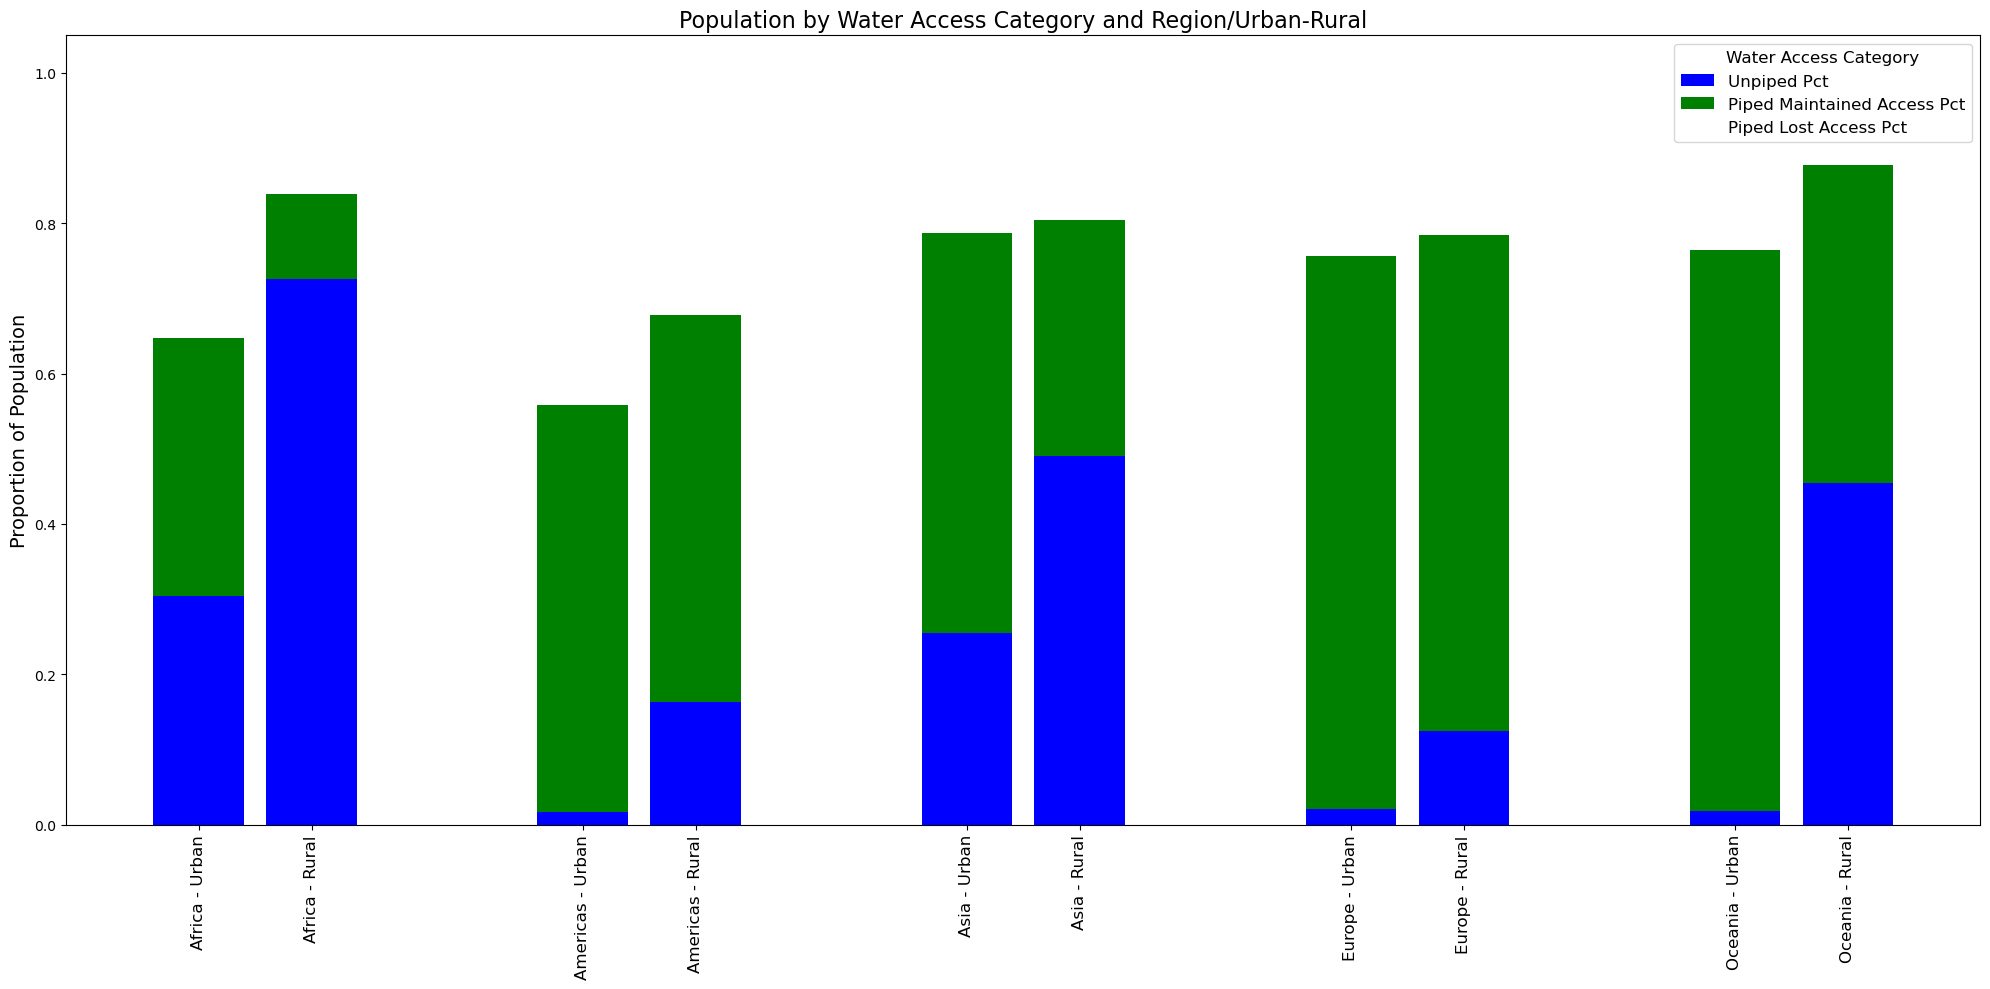

In [36]:

# ------------------------------------
# 3. Data Classification
# ------------------------------------
# Classify urban vs rural areas
df['urban_rural'] = np.where(df['GHS_SMOD'] > 15, 'Urban', 'Rural')

# Ensure correct types for certain columns
df['region'] = df['region'].astype(str)
df['Entity'] = df['Entity'].astype(str)

# Compute total population in each zone
df['total_pop'] = df['zone_pop_with_water'] + df['zone_pop_without_water']

# Assign "zone_piped" based on urban/rural classification and convert percentages to proportions
df['zone_piped'] = (np.where(df['urban_rural'] == 'Urban', df['URBANPiped'], df['RURALPiped'])) / 100

# Calculate the number of people with piped water in each zone
df['pop_with_piped'] = df['zone_piped'] * df['total_pop']

# Calculate the number of people without piped water in each zone
df['pop_without_piped'] = df['total_pop'] - df['pop_with_piped']

# Calculate people with piped water who lost access
df['pop_with_piped_and_lost_access'] = np.minimum(df['pop_with_piped'], df['zone_pop_without_water'])

# Calculate people with piped water who maintained access
df['pop_with_piped_and_maintained_access'] = df['pop_with_piped'] - df['pop_with_piped_and_lost_access']

# Fix floating-point precision issues by ensuring no negative values
columns_to_check = [
    'zone_pop_without_water',
    'pop_without_piped',
    'pop_with_piped_and_lost_access',
    'pop_with_piped_and_maintained_access'
]
for col in columns_to_check:
    df[col] = np.maximum(0, df[col])

# Now check again for negative values (to ensure no issues remain)
print("Checking for negative values after adjustment:")
print(df[['zone_pop_with_water', 'zone_pop_without_water', 'pop_with_piped', 'pop_without_piped',
          'pop_with_piped_and_lost_access', 'pop_with_piped_and_maintained_access']].min())

# ------------------------------------
# 4. Compute Percentiles for Each Category
# ------------------------------------
# Assign "zone_piped" for 5th and 95th percentiles and convert to proportions
df['zone_piped_5th'] = (np.where(df['urban_rural'] == 'Urban', df['URBANPiped_5th'], df['RURALPiped_5th'])) / 100
df['zone_piped_95th'] = (np.where(df['urban_rural'] == 'Urban', df['URBANPiped_95th'], df['RURALPiped_95th'])) / 100

# Calculate populations with piped water at 5th and 95th percentiles
df['pop_with_piped_5th'] = df['zone_piped_5th'] * df['total_pop']
df['pop_with_piped_95th'] = df['zone_piped_95th'] * df['total_pop']

# Calculate populations without piped water at 5th and 95th percentiles
df['pop_without_piped_5th'] = df['total_pop'] - df['pop_with_piped_5th']
df['pop_without_piped_95th'] = df['total_pop'] - df['pop_with_piped_95th']

# Calculate populations with piped water who lost access at 5th and 95th percentiles
df['pop_with_piped_and_lost_access_5th'] = np.minimum(df['pop_with_piped_5th'], df['zone_pop_without_water_5th'])
df['pop_with_piped_and_lost_access_95th'] = np.minimum(df['pop_with_piped_95th'], df['zone_pop_without_water_95th'])

# Calculate populations with piped water who maintained access at 5th and 95th percentiles
df['pop_with_piped_and_maintained_access_5th'] = df['pop_with_piped_5th'] - df['pop_with_piped_and_lost_access_5th']
df['pop_with_piped_and_maintained_access_95th'] = df['pop_with_piped_95th'] - df['pop_with_piped_and_lost_access_95th']

# Fix floating-point precision issues by ensuring no negative values
percentile_columns = [
    'zone_pop_without_water_5th',
    'zone_pop_without_water_95th',
    'pop_with_piped_and_lost_access_5th',
    'pop_with_piped_and_lost_access_95th',
    'pop_with_piped_and_maintained_access_5th',
    'pop_with_piped_and_maintained_access_95th',
    'pop_without_piped_5th',
    'pop_without_piped_95th'
]
for col in percentile_columns:
    if col in df.columns:
        df[col] = np.maximum(0, df[col])

# ------------------------------------
# 5. Grouping and Aggregation
# ------------------------------------
grouped = df.groupby(['region', 'urban_rural'])

aggregated_data = []

for name, group in grouped:
    region, urban_rural = name

    # Sum the populations at median
    total_pop_with_piped_and_lost_access = group['pop_with_piped_and_lost_access'].sum()
    total_pop_with_piped_and_maintained_access = group['pop_with_piped_and_maintained_access'].sum()
    total_pop_without_piped = group['pop_without_piped'].sum()
    total_population = (
        total_pop_with_piped_and_lost_access +
        total_pop_with_piped_and_maintained_access +
        total_pop_without_piped
    )

    # Sum the populations at 5th percentile
    pop_lost_5th = group['pop_with_piped_and_lost_access_5th'].sum()
    pop_maintained_5th = group['pop_with_piped_and_maintained_access_5th'].sum()
    pop_unpiped_5th = group['pop_without_piped_5th'].sum()
    total_5th = pop_lost_5th + pop_maintained_5th + pop_unpiped_5th

    # Sum the populations at 95th percentile
    pop_lost_95th = group['pop_with_piped_and_lost_access_95th'].sum()
    pop_maintained_95th = group['pop_with_piped_and_maintained_access_95th'].sum()
    pop_unpiped_95th = group['pop_without_piped_95th'].sum()
    total_95th = pop_lost_95th + pop_maintained_95th + pop_unpiped_95th

    # Calculate proportions
    piped_lost_pct = total_pop_with_piped_and_lost_access / total_population if total_population > 0 else np.nan
    piped_lost_pct_5th = pop_lost_5th / total_5th if total_5th > 0 else np.nan
    piped_lost_pct_95th = pop_lost_95th / total_95th if total_95th > 0 else np.nan

    piped_maintained_pct = total_pop_with_piped_and_maintained_access / total_population if total_population > 0 else np.nan
    piped_maintained_pct_5th = pop_maintained_5th / total_5th if total_5th > 0 else np.nan
    piped_maintained_pct_95th = pop_maintained_95th / total_95th if total_95th > 0 else np.nan

    unpiped_pct = total_pop_without_piped / total_population if total_population > 0 else np.nan
    unpiped_pct_5th = pop_unpiped_5th / total_5th if total_5th > 0 else np.nan
    unpiped_pct_95th = pop_unpiped_95th / total_95th if total_95th > 0 else np.nan

    # Append to aggregated data
    aggregated_data.append({
        'region': region,
        'Urban_Rural': urban_rural,
        'Total_Population': total_population,
        'Piped_Lost_Access': total_pop_with_piped_and_lost_access,
        'Piped_Lost_Access_5th': pop_lost_5th,
        'Piped_Lost_Access_95th': pop_lost_95th,
        'Piped_Maintained_Access': total_pop_with_piped_and_maintained_access,
        'Piped_Maintained_Access_5th': pop_maintained_5th,
        'Piped_Maintained_Access_95th': pop_maintained_95th,
        'Unpiped': total_pop_without_piped,
        'Unpiped_5th': pop_unpiped_5th,
        'Unpiped_95th': pop_unpiped_95th,
        'Total': total_population,
        'Piped_Lost_Access_pct': piped_lost_pct,
        'Piped_Lost_Access_pct_5th': piped_lost_pct_5th,
        'Piped_Lost_Access_pct_95th': piped_lost_pct_95th,
        'Piped_Maintained_Access_pct': piped_maintained_pct,
        'Piped_Maintained_Access_pct_5th': piped_maintained_pct_5th,
        'Piped_Maintained_Access_pct_95th': piped_maintained_pct_95th,
        'Unpiped_pct': unpiped_pct,
        'Unpiped_pct_5th': unpiped_pct_5th,
        'Unpiped_pct_95th': unpiped_pct_95th,
    })

# Create DataFrame from aggregated data
agg_df = pd.DataFrame(aggregated_data)

# ------------------------------------
# 6. Arrange Bars as Urban-Rural per Region
# ------------------------------------
# Reset index to manipulate sorting
agg_df = agg_df.reset_index(drop=True)

# Create an order for 'Urban_Rural' to ensure 'Urban' comes first
agg_df['Urban_Rural_order'] = agg_df['Urban_Rural'].map({'Urban': 0, 'Rural': 1})

# Sort by 'region' and 'Urban_Rural_order'
agg_df = agg_df.sort_values(['region', 'Urban_Rural_order'])

# Recreate the 'Group' index
agg_df['Group'] = agg_df['region'] + ' - ' + agg_df['Urban_Rural']
agg_df = agg_df.set_index('Group')

# Drop the temporary order column
agg_df = agg_df.drop(columns=['Urban_Rural_order'])

# ------------------------------------
# 7. Visualization: Stacked Bar Plot Without Error Bars
# ------------------------------------
import matplotlib.pyplot as plt

# Prepare the data for plotting
categories = ['Unpiped_pct', 'Piped_Maintained_Access_pct', 'Piped_Lost_Access_pct']
colors = ['blue', 'green', 'white']  # Choose appropriate colors

# Get unique regions to manage grouping
unique_regions = agg_df['region'].unique()

# Number of regions
num_regions = len(unique_regions)

# Define the number of bars per region (Urban and Rural)
bars_per_region = 2

# Define spacing
bar_width = 0.4  # Width of each bar
gap_between_bars = 0.1  # Gap between Urban and Rural within the same region
gap_between_regions = 0.8  # Gap between different regions

# Calculate total width per region
total_width_per_region = bars_per_region * bar_width + gap_between_bars

# Initialize lists for positions and labels
x_positions = []
labels = []

# Iterate over regions and assign positions
for i, region in enumerate(unique_regions):
    # Base position for the region
    base = i * (total_width_per_region + gap_between_regions)

    # Urban bar position
    urban_x = base
    x_positions.append(urban_x)
    labels.append(f"{region} - Urban")

    # Rural bar position
    rural_x = base + bar_width + gap_between_bars
    x_positions.append(rural_x)
    labels.append(f"{region} - Rural")

# Prepare the data in the order of x_positions
plot_df = agg_df.reset_index().set_index('Group').loc[labels]

# Extract proportions for each category
unpiped = plot_df['Unpiped_pct'].values
piped_maintained = plot_df['Piped_Maintained_Access_pct'].values
piped_lost = plot_df['Piped_Lost_Access_pct'].values

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))

# Initialize bottom for stacking
bottom = np.zeros(len(plot_df))

# Plot each category
for idx, (category, color) in enumerate(zip(categories, colors)):
    if category == 'Unpiped_pct':
        values = unpiped
    elif category == 'Piped_Maintained_Access_pct':
        values = piped_maintained
    elif category == 'Piped_Lost_Access_pct':
        values = piped_lost
    ax.bar(x_positions, values, bar_width, bottom=bottom, color=color, label=category.replace('_', ' ').title())
    bottom += values

# Customizing the plot
ax.set_ylabel('Proportion of Population', fontsize=14)
ax.set_title('Population by Water Access Category and Region/Urban-Rural', fontsize=16)

# Set x-ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, rotation=90, fontsize=12)

# Add legend
ax.legend(title='Water Access Category', fontsize=12, title_fontsize=12)

# Adjust layout for better fit
plt.tight_layout()

# Display the plot
plt.show()


In [31]:
from pathlib import Path

# Define the root of the repository by going up one level from the script directory
data_script_dir = Path.cwd()
repo_root = data_script_dir.parent

# Define the paths to the Parquet file and the original CSV file
country_data = repo_root / "data" / "processed" / "merged_data.csv"

# Read the country data
country_data_df = pd.read_csv(country_data)

# Merge country data with median, 5th, and 95th percentile results
merged_data = country_data_df.merge(country_medians, left_on='alpha3', right_on='ISOCODE', suffixes=('', '_median'))
merged_data = merged_data.merge(country_5th_percentiles, left_on='alpha3', right_on='ISOCODE', suffixes=('', '_5th'))
merged_data = merged_data.merge(country_95th_percentiles, left_on='alpha3', right_on='ISOCODE', suffixes=('', '_95th'))

# Display the first few rows of the merged dataframe
print(merged_data.head())

# Check the shape of the merged dataframe
print(f"Shape of merged dataframe: {merged_data.shape}")

# List of columns in the merged dataframe
print(f"Columns in merged dataframe: {merged_data.columns.tolist()}")



# Select the required columns for the new dataframe
combined_df = merged_data[['country_pop_raw', 'population_piped_with_only_cycling_access', 'population_piped_with_walking_access', 'country_pop_without_water' ,'PBO']]

# Display the first few rows of the combined dataframe
print(combined_df.head())

# Check the shape of the combined dataframe
print(f"Shape of combined dataframe: {combined_df.shape}")

# List of columns in the combined dataframe
print(f"Columns in combined dataframe: {combined_df.columns.tolist()}")








  alpha3  RURALPiped  URBANPiped     PBO  Average Weight  Household_Size  \
0    AFG        17.0        42.0  31.820       54.717515            8.04   
1    ALB        76.0        84.0  21.400       70.408587            3.30   
2    DZA        60.0        75.0  23.378       65.056869            4.94   
3    AGO         8.0        59.0   8.700       56.053693            4.82   
4    ARG        82.0       100.0  72.490       72.595308            2.95   

  alpha2 Continent  % urban  Population  ...  \
0     AF        AS     27.0    39835428  ...   
1     AL        EU     64.0     2872934  ...   
2     DZ        AF     75.0    44616626  ...   
3     AO        AF     68.0    33933611  ...   
4     AR        SA     92.0    45605823  ...   

  percent_piped_with_cycling_access_95th  \
0                               5.787643   
1                              16.493308   
2                               9.994242   
3                               2.288866   
4                              53.

/var/folders/74/zlkzxgsj71d9nm329swsh11c0000gn/T/ipykernel_76775/3325385988.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of entries per PBO bin:
0-10%      20
10-20%     21
20-30%     28
30-40%     34
40-50%     30
50-60%     15
60-70%     15
70-80%     10
80-90%      7
90-100%     0
Name: PBO_binned, dtype: int64


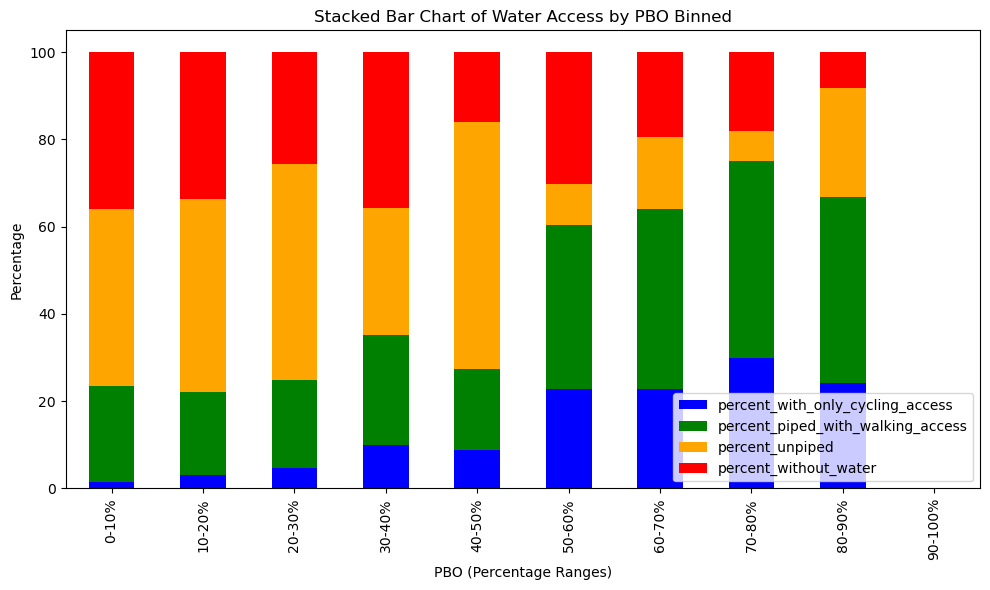

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the bins and labels for the PBO column
bins = [i for i in range(0, 110, 10)]  # Bins for 0-10%, 10-20%, ..., 90-100%
bin_labels = [f'{i}-{i+10}%' for i in range(0, 100, 10)]  # Labels for the bins

# Bin the PBO column into these specified ranges
combined_df['PBO_binned'] = pd.cut(combined_df['PBO'], bins=bins, labels=bin_labels, right=False)

# Check how many entries fall within each bin
bin_counts = combined_df['PBO_binned'].value_counts().sort_index()
print("Number of entries per PBO bin:")
print(bin_counts)

# Group by the binned PBO and sum the absolute populations
grouped_df = combined_df.groupby('PBO_binned').sum()

# Calculate percentages for each category
grouped_df['percent_with_only_cycling_access'] = grouped_df['population_piped_with_only_cycling_access'] / grouped_df['country_pop_raw'] * 100
grouped_df['percent_piped_with_walking_access'] = grouped_df['population_piped_with_walking_access'] / grouped_df['country_pop_raw'] * 100
grouped_df['percent_without_water'] = grouped_df['country_pop_without_water'] / grouped_df['country_pop_raw'] * 100

# Calculate the unpiped percentage as the remainder (100% - sum of other percentages)
grouped_df['percent_unpiped'] = 100 - (grouped_df['percent_with_only_cycling_access'] + 
                                       grouped_df['percent_piped_with_walking_access'] + 
                                       grouped_df['percent_without_water'])

# Define the order of the stacks and their colors
stack_order = ['percent_with_only_cycling_access','percent_piped_with_walking_access', 'percent_unpiped', 'percent_without_water']
colors = ['blue', 'green', 'orange', 'red']  # Define 'red' for 'percent_without_water'

# Now let's plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create the stacked bar chart with defined stack order and colors
grouped_df[stack_order].plot(kind='bar', stacked=True, ax=ax, color=colors)

# Add labels and title
ax.set_xlabel('PBO (Percentage Ranges)')
ax.set_ylabel('Percentage')
ax.set_title('Stacked Bar Chart of Water Access by PBO Binned')

# Update the x-axis labels with the bin names
ax.set_xticklabels(bin_labels)

# Display the chart
plt.tight_layout()
plt.show()
